In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Create Input Space and Starting Parameters

In [2]:
start_time=300                         #starting point in ms 
#start_current=9                       #input current in amperes 
time_step=0.005                          #time increments  


y=np.arange(0,1000.1,time_step) 

                                        #function that injects current at certain time
def start(start_time,I):
    x=np.zeros((len(y)))                #create empty array to plot current

    for i in range (0,len(y)):     
        if y[i] >start_time:            #when we reach start time, start plotting input current 
            x[i]= I          #each second afterwards will hold the constant value of the input current 
    return x

#  Calculate Differential Equations 

In [3]:
#these equations are not linear so they need to be approximated using Euler approximation
#we rewrite the derivatives to show the change in voltage over change in time between two different timesteps 
def equations(current,u,v,a,b): 
    v = v+time_step*(0.04*v**2+5*v+140-u+current)
    u = u+time_step*(a*(b*v-u))
    
    return u,v 

# Create the Izhikevich Model 

In [12]:
def model(a,b,c,d,I,plot=False): 
    v = -65*np.ones((len(y)))         #creates the baseline array that holds the resting membrane potential 
    u = np.zeros((len(y)))            #initialize values for membrane recovery rate 
    u[0] = b*-65                      #initial value for u 
    
    spikes = np.zeros(len(y))
    current = start(start_time,I)
    for i in range(0,len(y)-1):
        u[i+1],v[i+1]  = equations(current[i],u[i],v[i],a,b)
                                    #after the spike reaches apex of 30mV, membrane voltage and recovery are reset
        if v[i+1] > 30:      
            v[i+1] = c 
            u[i+1] = u[i+1]+d
            spikes[i+1]  = 1 # one means there's a spike generated at the given time step
            
    plotting(current,v,a,b,c,d,y,plot)
    return np.where(spikes>0)   # return the timesteps where spikes were generated


# Plotting Current as a Function of Time and Membrane Potential 

In [16]:
def plotting(current,v,a,b,c,d,y,plot=False):
    #PLOT OUTPUT CURRENT 
    if plot:
        fig, ax1 = plt.subplots(figsize=(12,7))
        ax1.plot(y, v, label = 'Output')
        ax1.set_xlabel('Time in ms')
        ax1.set_ylabel('Output in mV', color='k')
        ax1.tick_params('y', colors='k')
        ax1.set_ylim(-95,40)
        ax1.set_title('Input Current: %s A ' %(int(current[-1])))
        plt.show()
 

# Test Izhikevich Model

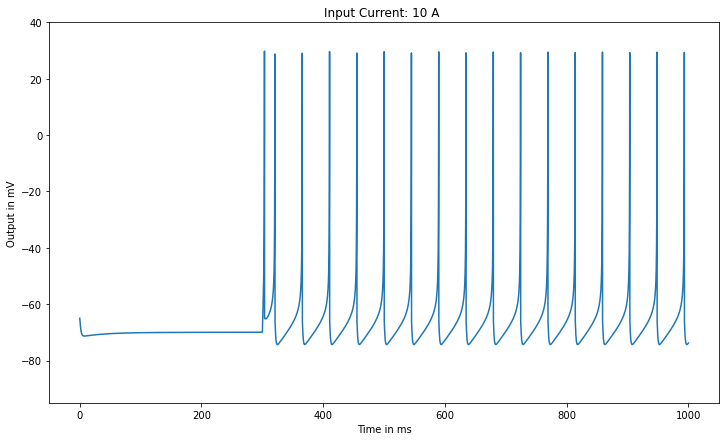

where the spikes were generated:  (array([ 60694,  64125,  73116,  82083,  91050, 100017, 108984, 117951,
       126918, 135885, 144852, 153819, 162786, 171753, 180720, 189687,
       198654]),)
Number of spike generated over time:  17


In [19]:
spikes = model(0.02,0.2,-65,8,10,plot=True) # current is 10
print("where the spikes were generated: ", spikes)
print("Number of spike generated over time: ",len(spikes[0]))

# Boolean functions

In [8]:
def BooleanFunc(inputs,AND = True):
    if AND:
        # all 1 return 1, otherwise 0
        if np.sum(inputs) == len(inputs):
            return 1
        else:
            return 0
    else: ### OR
        # all 0 then 0, otherwise 1
        if np.sum(inputs) == 0:
            return 0
        else:
            return 1

# Encode Scheme, Train Weights for AND Gates

In [9]:
#USING PERCEPTRON RULE 
def training(iterations,alpha,data,answers):
    #initialize all weights to 0 
    w1=np.zeros(1)
    w2=np.zeros(1)
    #initialize bias to 0 
    b = np.zeros(1)
    
    
    for j in range(iterations):
        for i in range(len(data)):
            #data[i][0] and data[i][1] correspond to first input and second input, respectively 
            current = data[i] * 10 # the current would be the individual input multiplying 10
            out = np.zeros_like(data[i]) 
            for x in range(len(current)):
                # stimulate each Izhikevich neuron at the input layer to get the spikes
                spike = model(0.02,0.2,-65,8,current[x])
                
                if len(spike[0]) > 0:
                    # if there were spikes generated, it means the input neuron fired in response to the current,
                    # thus, the status of this input neuron is marked as "1" meaning "fired"
                    out[x] = 1 
                else:
                    # otherwise, it means the input neuron did not fire in response to the current,
                    # thus, the status of this input neuron is marked as "0" meaning "silent"
                    out[x] = 0

            # Obtain the weighted input that would be fed to the output neuron: multiply the finalized weight
            # by the output of the input neuron following the perceptral rule
            eq = w1*out[0] + w2*out[1] + b 
            if eq > 0: 
                weighted_I = 1 
            else:
                weighted_I = 0
            
            # stimulate the output neuron on the output layer with the current(weighted input * 10)
            spike = model(0.02,0.2,-65,8,weighted_I * 10) 
            if len(spike[0])> 0:
                # if there were spikes generated, it means the output neuron fired in response to the weighted input(current),
                # thus, the status of this output neuron is marked as "1" meaning "fired"
                result = 1
            else:
                # otherwise, it means the output neuron did not fire in response to the weighted input(current),
                # thus, the status of this output neuron is marked as "0" meaning "silent"
                result = 0
            
            #update weights and bias
            w1 += alpha*(answers[i]-result)*data[i][0]
            w2 += alpha*(answers[i]-result)*data[i][1]
            b += alpha*(answers[i]-result)

    return w1,w2,b

alpha=0.1
#input data 
data = np.array([[0,0],[1,1],[1,0],[0,1]])
#change answers to correspond to gate. Currently set to AND gate 
answers = []
for i in range(len(data)):  
    answers.append(BooleanFunc(data[i],AND = True)) # True: AND; # False: OR
answers = np.array(answers)

#get finalized weights    
w1,w2,b = training(10,alpha,data,answers)

# Test, Decode Scheme for AND Gate

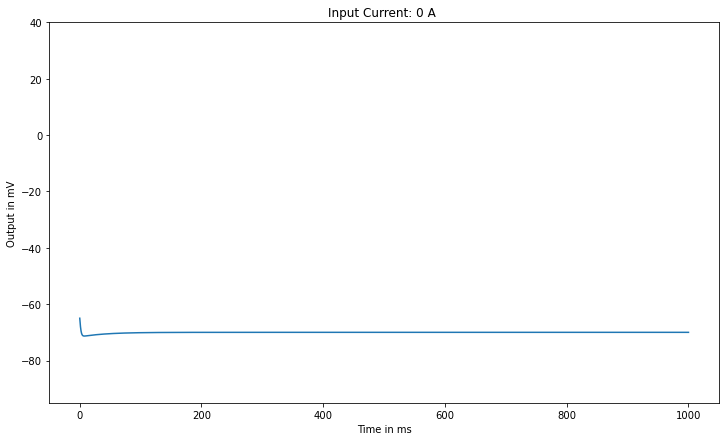

0


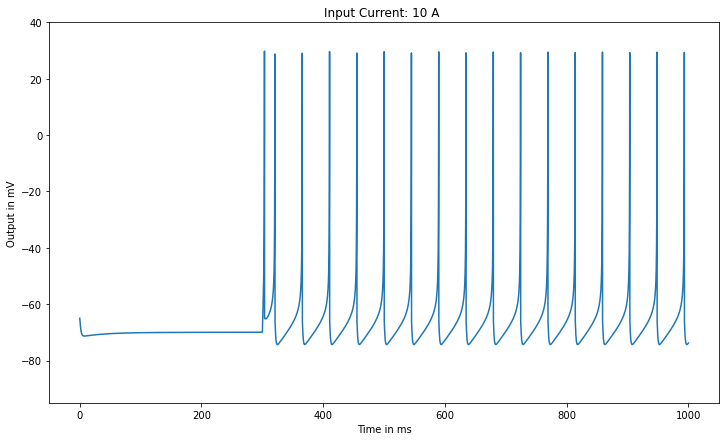

1


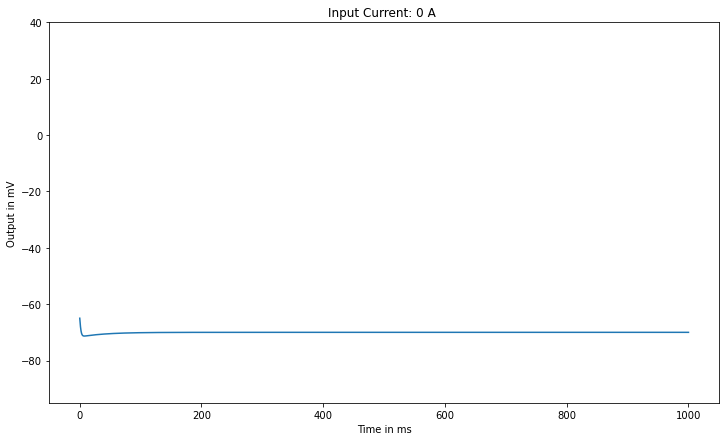

0


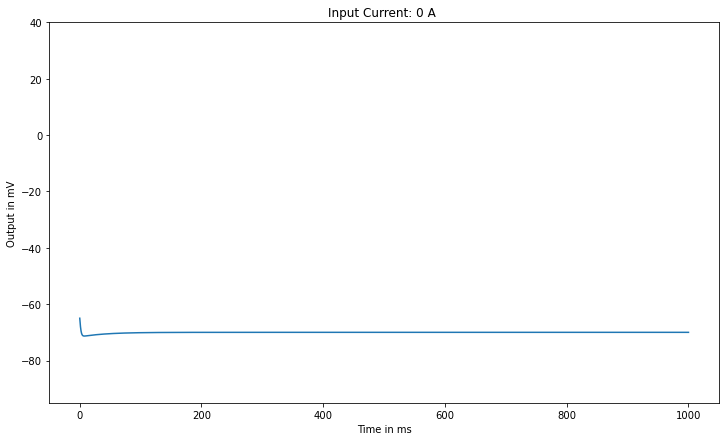

0


In [21]:
results = []

for i in range(len(data)): 
    neuralData = np.zeros([3,17]) # for raster plot
    
    #data[i][0] and data[i][1] correspond to first input and second input, respectively 
    current = data[i] * 10 # the current would be the individual input multiplying by 10
    out = np.zeros_like(data[i]) 
    for x in range(len(current)):
        # stimulate each Izhikevich neuron at the input layer to get the spikes
        spike = model(0.02,0.2,-65,8,current[x])
        if len(spike[0]) > 0:
            # if there were spikes generated, it means the input neuron fired in response to the current,
            # thus, the status of this input neuron is marked as "1" meaning "fired"
            out[x] = 1 
            neuralData[x,:] = spike[0]*time_step/1000.0
        else:
            # otherwise, it means the input neuron did not fire in response to the current,
            # thus, the status of this input neuron is marked as "0" meaning "silent"
            out[x] = 0
            neuralData[x,:] = -1+neuralData[x,:]
                     
    # Obtain the weighted input that would be fed to the output neuron: multiply the finalized weight
    # by the output of the input neuron following the perceptral rule
    eq = w1*out[0] + w2*out[1] + b
    if eq > 0: 
        weighted_I = 1 
    else:
        weighted_I = 0 

    #print("weighted_input: ",weighted_I)
    # stimulate the output neuron on the output layer with the current(weighted input * 10)
    spike = model(0.02,0.2,-65,8,weighted_I*10)
    
    if len(spike[0]) > 0:
        # if there were spikes generated, it means the output neuron fired in response to the weighted input(current),
        # thus, the status of this output neuron is marked as "1" meaning "fired"
        result = 1 
        neuralData[2,:] = spike[0]*time_step/1000.0
    else:
        # otherwise, it means the output neuron did not fire in response to the weighted input(current),
        # thus, the status of this output neuron is marked as "0" meaning "silent"
        result = 0
        neuralData[2,:] = -1+neuralData[2,:]
    
    if i == 0:
        first = neuralData # when input is [0,0]
    elif i == 1:
        second = neuralData # when input is [1,1]
    elif i == 2:
        third = neuralData # when input is [1,0]
    elif i == 3:
        fourth = neuralData # when input is [0,1]
    
    #3A is minimum current to produce one spike 
    #decode 0,1 to represent spike by multiplying 10 
    model(0.02,0.2,-65,8,result*10,plot=True)
   
    results.append(result)
    
    print(result)
    
results = np.asarray(results)


# Raster Plot for AND Gate

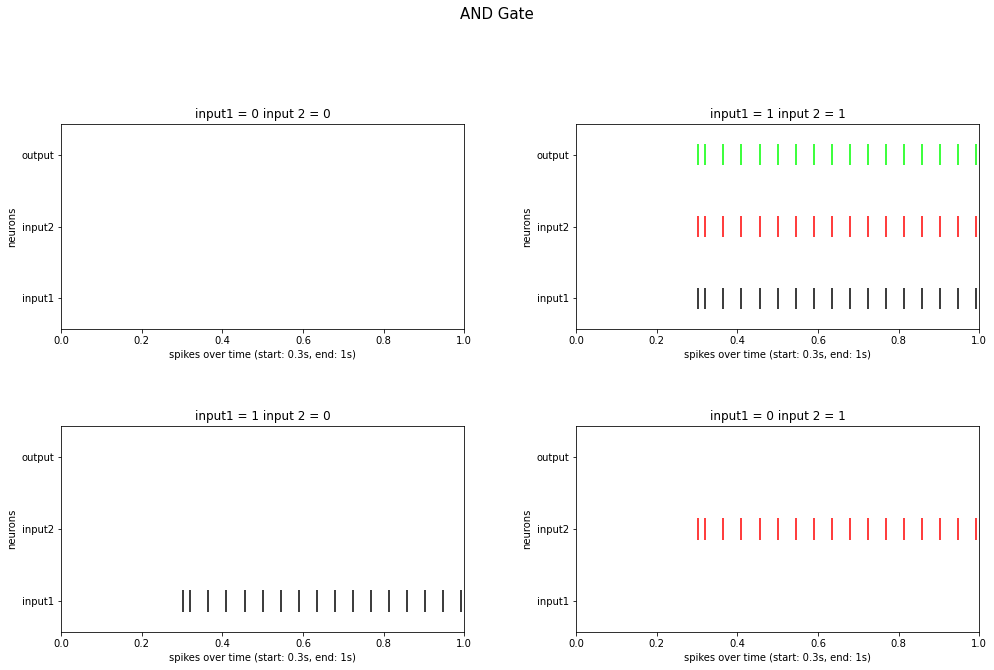

In [22]:
fig, axs = plt.subplots(2, 2, figsize = ((15,10))) 

colorCodes = np.array([[0,0,0],
                        [1,0,0],
                        [0,1,0]])
lineSize = [0.3,0.3,0.3]

axs[0,0].eventplot(first, color=colorCodes, linelengths = lineSize) 
axs[0,0].set(xlabel = 'spikes over time (start: 0.3s, end: 1s)', ylabel = 'neurons')
plt.sca(axs[0, 0])
axs[0,0].set_xlim(0, 1)
axs[0,0].set_title("input1 = 0 input 2 = 0")
plt.yticks(range(3), ['input1', 'input2', 'output'], color='black')


axs[0,1].eventplot(second, color=colorCodes, linelengths = lineSize) 
axs[0,1].set(xlabel = 'spikes over time (start: 0.3s, end: 1s)', ylabel = 'neurons')
plt.sca(axs[0, 1])
axs[0,1].set_xlim(0, 1)
axs[0,1].set_title("input1 = 1 input 2 = 1")
plt.yticks(range(3), ['input1', 'input2', 'output'], color='black')


axs[1,0].eventplot(third, color=colorCodes, linelengths = lineSize) 
axs[1,0].set(xlabel = 'spikes over time (start: 0.3s, end: 1s)', ylabel = 'neurons')
plt.sca(axs[1, 0])
axs[1,0].set_xlim(0, 1)
axs[1,0].set_title("input1 = 1 input 2 = 0")
plt.yticks(range(3), ['input1', 'input2', 'output'], color='black')


axs[1,1].eventplot(fourth, color=colorCodes, linelengths = lineSize) 
axs[1,1].set(xlabel = 'spikes over time (start: 0.3s, end: 1s)', ylabel = 'neurons')
plt.sca(axs[1, 1])
axs[1,1].set_xlim(0, 1)
axs[1,1].set_title("input1 = 0 input 2 = 1")
plt.yticks(range(3), ['input1', 'input2', 'output'], color='black')



plt.suptitle('AND Gate',fontsize = 15)
#plt.suptitle('OR Gate',fontsize = 15)
# Display the spike raster plot

fig.tight_layout(pad=5.0)

plt.show()

# Same Schemes for OR Gates

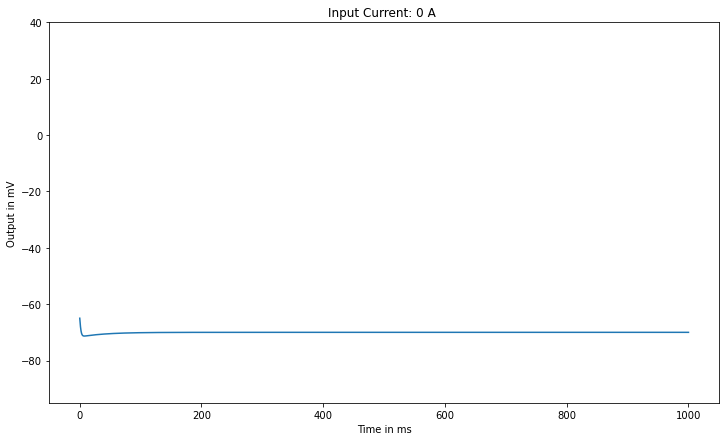

0


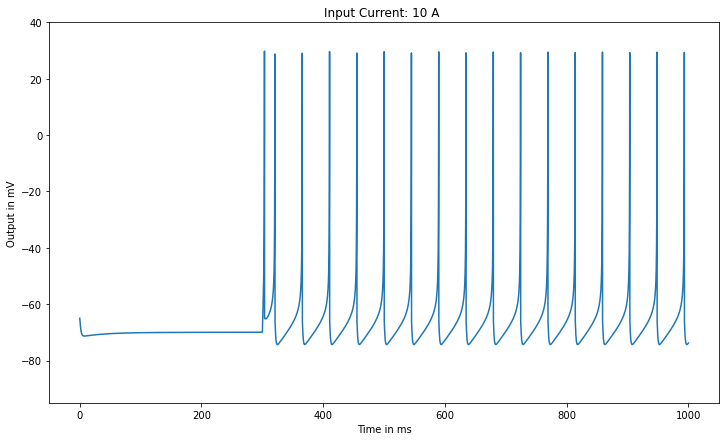

1


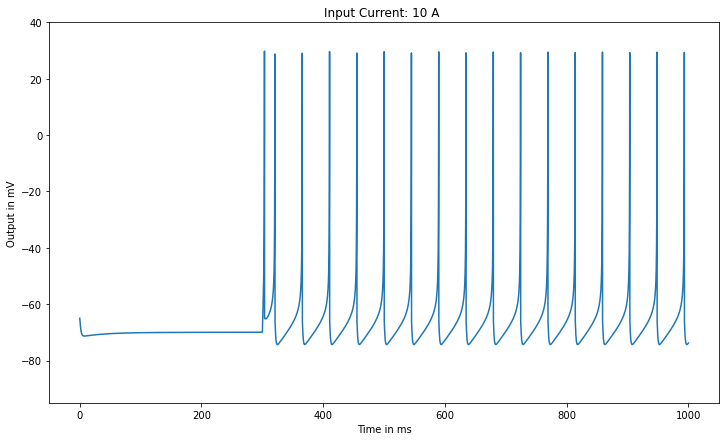

1


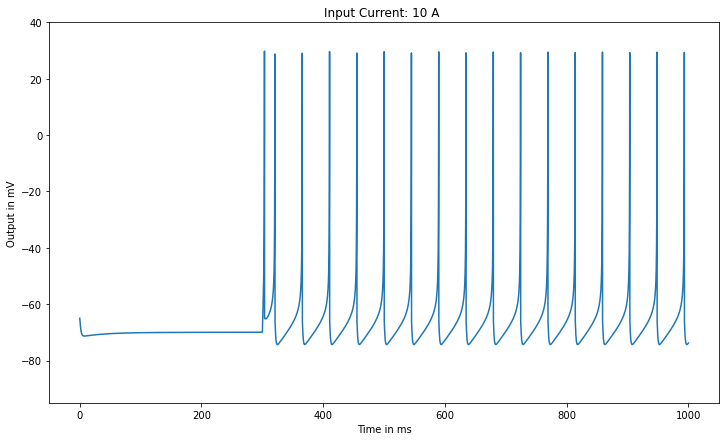

1


In [25]:
#Using the same scheme for OR gate training
alpha=0.1
#input data 
data = np.array([[0,0],[1,1],[1,0],[0,1]])
#change answers to correspond to gate. Currently set to OR gate 
answers = []
for i in range(len(data)):  
    answers.append(BooleanFunc(data[i],AND = False)) # True: AND; # False: OR
answers = np.array(answers)

#get finalized weights    
w1,w2,b = training(10,alpha,data,answers)

#Test
results = []

for i in range(len(data)): 
    neuralData = np.zeros([3,17]) # for raster plot
    
    #data[i][0] and data[i][1] correspond to first input and second input, respectively 
    current = data[i] * 10 # the current would be the individual input multiplying by 10
    out = np.zeros_like(data[i]) 
    for x in range(len(current)):
        # stimulate each Izhikevich neuron at the input layer to get the spikes
        spike = model(0.02,0.2,-65,8,current[x])
        if len(spike[0]) > 0:
            # if there were spikes generated, it means the input neuron fired in response to the current,
            # thus, the status of this input neuron is marked as "1" meaning "fired"
            out[x] = 1 
            neuralData[x,:] = spike[0]*time_step/1000.0
        else:
            # otherwise, it means the input neuron did not fire in response to the current,
            # thus, the status of this input neuron is marked as "0" meaning "silent"
            out[x] = 0
            neuralData[x,:] = -1+neuralData[x,:]
                     
    # Obtain the weighted input that would be fed to the output neuron: multiply the finalized weight
    # by the output of the input neuron following the perceptral rule
    eq = w1*out[0] + w2*out[1] + b
    if eq > 0: 
        weighted_I = 1 
    else:
        weighted_I = 0 

    #print("weighted_input: ",weighted_I)
    # stimulate the output neuron on the output layer with the current(weighted input * 10)
    spike = model(0.02,0.2,-65,8,weighted_I*10)
    
    if len(spike[0]) > 0:
        # if there were spikes generated, it means the output neuron fired in response to the weighted input(current),
        # thus, the status of this output neuron is marked as "1" meaning "fired"
        result = 1 
        neuralData[2,:] = spike[0]*time_step/1000.0
    else:
        # otherwise, it means the output neuron did not fire in response to the weighted input(current),
        # thus, the status of this output neuron is marked as "0" meaning "silent"
        result = 0
        neuralData[2,:] = -1+neuralData[2,:]
    
    if i == 0:
        first = neuralData # when input is [0,0]
    elif i == 1:
        second = neuralData # when input is [1,1]
    elif i == 2:
        third = neuralData # when input is [1,0]
    elif i == 3:
        fourth = neuralData # when input is [0,1]
    
    #3A is minimum current to produce one spike 
    #decode 0,1 to represent spike by multiplying 10 
    model(0.02,0.2,-65,8,result*10,plot=True)
   
    results.append(result)
    
    print(result)
    
results = np.asarray(results)



# Raster Plot for OR Gate

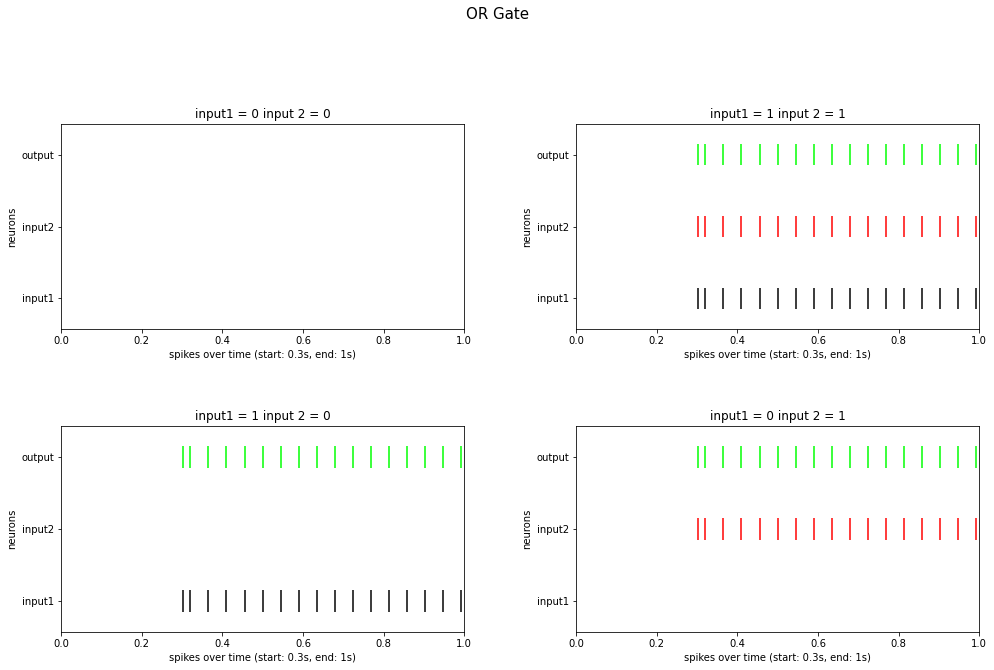

In [26]:
fig, axs = plt.subplots(2, 2, figsize = ((15,10))) 

colorCodes = np.array([[0,0,0],
                        [1,0,0],
                        [0,1,0]])
lineSize = [0.3,0.3,0.3]

axs[0,0].eventplot(first, color=colorCodes, linelengths = lineSize) 
axs[0,0].set(xlabel = 'spikes over time (start: 0.3s, end: 1s)', ylabel = 'neurons')
plt.sca(axs[0, 0])
axs[0,0].set_xlim(0, 1)
axs[0,0].set_title("input1 = 0 input 2 = 0")
plt.yticks(range(3), ['input1', 'input2', 'output'], color='black')


axs[0,1].eventplot(second, color=colorCodes, linelengths = lineSize) 
axs[0,1].set(xlabel = 'spikes over time (start: 0.3s, end: 1s)', ylabel = 'neurons')
plt.sca(axs[0, 1])
axs[0,1].set_xlim(0, 1)
axs[0,1].set_title("input1 = 1 input 2 = 1")
plt.yticks(range(3), ['input1', 'input2', 'output'], color='black')


axs[1,0].eventplot(third, color=colorCodes, linelengths = lineSize) 
axs[1,0].set(xlabel = 'spikes over time (start: 0.3s, end: 1s)', ylabel = 'neurons')
plt.sca(axs[1, 0])
axs[1,0].set_xlim(0, 1)
axs[1,0].set_title("input1 = 1 input 2 = 0")
plt.yticks(range(3), ['input1', 'input2', 'output'], color='black')


axs[1,1].eventplot(fourth, color=colorCodes, linelengths = lineSize) 
axs[1,1].set(xlabel = 'spikes over time (start: 0.3s, end: 1s)', ylabel = 'neurons')
plt.sca(axs[1, 1])
axs[1,1].set_xlim(0, 1)
axs[1,1].set_title("input1 = 0 input 2 = 1")
plt.yticks(range(3), ['input1', 'input2', 'output'], color='black')


plt.suptitle('OR Gate',fontsize = 15)
# Display the spike raster plot

fig.tight_layout(pad=5.0)

plt.show()